# **Twitter Sentiment Analysis 💬👍👎**

We will perform data analysis and classification on covid-19 vaccine related tweets, on their sentiment.  
More specifically, we will classify them into three classes, *positive*, *negative* and *neutral*.  
We will use several classifiying techniques such as **Support Vector Machines (SVM)**, **Random Forests** and **K-Nearest Neighbours (KNN)**.  
For each classifier we will use several vectorization techniques (**Bag of Words**, **TF-IDF**, **Word2Vec embeddings** , **GloVe embeddings**) as well.  
**Note:** As the classifiers take some time to train on the data, for sake of speed we are going to use a random (with seed) sample of **100K** data which is nearly the half of them.

In [1]:
# Some initial imports #

import os
import time
import pickle 
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## **Load the dataset** 🗂

In [2]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/eclass_all_with_sentiment_v2.pkl'
dataset = pd.read_pickle(DATA_PATH)
dataset = dataset.sample(100000, random_state=1) # take a random sample of the dataset of specified size (better than .head())#
dataset = dataset.dropna(subset=["text"]) # drop rows with missing text (if any)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


What is the shape of the data, and how do they look? 👀 

In [3]:
print(f"Dataset shape: {dataset.shape}")

pd.set_option('display.max_colwidth', 1000)
dataset.head()

Dataset shape: (100000, 17)


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
64813,1384446688237133825,ExperiencedTraveller,London,"Addicted to all things related to travel - talk, write and tweet about it - my main outlet is https://t.co/7K8nH6rLku",2010-04-21 20:43:27,10309,11230,280,False,2021-04-20 09:59:46,#MondayBlogs My #coronavirusdiary records in Week 55 of the #coronaviruspandemic the sad news that #PrincePhilip… https://t.co/hOHqTyBg12,"['MondayBlogs', 'coronavirusdiary', 'coronaviruspandemic', 'PrincePhilip']",Twitter Web App,0,0,False,NEG
35009,1373922903234912256,Liam Thomas Politics #StayAlertSaveLives,United Kingdom,Tweeting the day’s unfolding political stories and breaking news. Morning and Evening summaries. Mon-Fri 9AM - 7PM. Sat 9AM - 5PM,2017-06-28 16:56:47,32,1324,1262,False,2021-03-22 09:02:01,Good morning. Evening summary at 7pm\n\nBoris Johnson is expected to speak to his EU counterparts this week as a row… https://t.co/Smx9kJS05s,NaN,Twitter for iPad,0,0,False,NEU
31335,1372277188335173635,Karen Parrish,"High Point, NC","Wife of Robin, author of books; Mom of Evan and Emma. Lover of cake and fruit.",2008-07-24 19:06:33,41,396,587,False,2021-03-17 20:02:32,"We both got our shot! Well, the first one, at least. #notthrowingawaymyshot #moderna https://t.co/kV7jbv524b","['notthrowingawaymyshot', 'moderna']",Instagram,0,0,False,NEG
22693,1367836353124167683,ranjan kumar,NaN,NaN,2017-01-13 14:11:12,25,56,49,False,2021-03-05 13:56:14,Why Is The Congress-Left Party Putting The Lives Of Common People At Risk For Its Politics?\n\n#Congress #COVID19… https://t.co/twitGHveJK,"['Congress', 'COVID19']",Twitter for Android,1,0,False,NEG
41242,1376539297319317507,Workout Solutions,"Toronto, Canada and Worldwide","George Tsanis – Workout Solutions Health and Fitness Consultants since 1996 – One-on-one and online distance coaching – Toronto, Canada, World",2010-09-20 17:01:08,1190,206,1837,False,2021-03-29 14:18:38,@celliottability Moscow Russia everything is open business as usual. Ontario Canada is reporting 2094 cases of… https://t.co/MNsgbVC3uE,NaN,Twitter for iPhone,1,0,False,NEU


It seems that `date`, `text` and `sentiment` columns are the useful ones, so let's get rid of the rest.

In [4]:
# Keep a copy of dataset for beat the benchmark use
dataset4Benchmark = dataset.copy(deep=True)

# Keep a copy of dataset for some data analysis later on
dataset2 = dataset.copy(deep=True)

# Drop unnecessary columns 
dataset2.drop(columns = ['id', 'user_name',	'user_location',	'user_created',
              'user_friends',	'user_favourites',	'text', 'date', 'hashtags', 'source',
              'retweets', 'favorites', 'is_retweet'], inplace=True)

dataset.drop(columns = ['id', 'retweets', 'user_name',	'user_location',	'user_description',	'user_created',
              'user_followers',	'user_friends',	'user_favourites',	'user_verified', 'hashtags',
              'source', 'favorites', 'is_retweet'], inplace=True)
dataset.head()

,date,text,sentiment
64813,2021-04-20 09:59:46,#MondayBlogs My #coronavirusdiary records in Week 55 of the #coronaviruspandemic the sad news that #PrincePhilip… https://t.co/hOHqTyBg12,NEG
35009,2021-03-22 09:02:01,Good morning. Evening summary at 7pm\n\nBoris Johnson is expected to speak to his EU counterparts this week as a row… https://t.co/Smx9kJS05s,NEU
31335,2021-03-17 20:02:32,"We both got our shot! Well, the first one, at least. #notthrowingawaymyshot #moderna https://t.co/kV7jbv524b",NEG
22693,2021-03-05 13:56:14,Why Is The Congress-Left Party Putting The Lives Of Common People At Risk For Its Politics?\n\n#Congress #COVID19… https://t.co/twitGHveJK,NEG
41242,2021-03-29 14:18:38,@celliottability Moscow Russia everything is open business as usual. Ontario Canada is reporting 2094 cases of… https://t.co/MNsgbVC3uE,NEU


Convert the sentiments as following:

* POS → 0
* NEG → 1
* NEU → 2


In [5]:
dataset['sentiment'] = dataset['sentiment'].replace("POS", 0)
dataset['sentiment'] = dataset['sentiment'].replace("NEG", 1)
dataset['sentiment'] = dataset['sentiment'].replace("NEU", 2)

## **Data pre-processing** 💽

In order to pass our data to the several classifiers you are going to experiment with, they must first be pre-processed.  
Some common preprocessing steps includes *data cleaning*, *data vectorization* and *dataset split*.

### **Data cleaning** 🧹


In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Define the function for text cleaning
def text_cleaning(text):
  # Lower characters
  text = text.lower()
  # Remove links
  text = re.sub('http://\S+|https://\S+', '', text)
  # Remove non letter characters
  text = re.sub(r'[^A-Za-z]+', ' ', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  StopWords = stopwords.words("english")
  text = ' '.join([word for word in text.split() if word not in StopWords])
  
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
dataset['text'] = dataset['text'].apply(text_cleaning)

In [8]:
dataset['text'].head(10)

64813              mondayblogs coronavirusdiary records week coronaviruspandemic sad news princephilip
35009            good morning evening summary pm boris johnson expected speak eu counterparts week row
31335                                      got shot well first one least notthrowingawaymyshot moderna
22693                     congress left party putting lives common people risk politics congress covid
41242      celliottability moscow russia everything open business usual ontario canada reporting cases
211801                          sounds like positive development hope vaccine approved oct end covaxin
204940                   bharat biotech covaxin gets emergency use approval children years age covaxin
5867      good news covid nicaragua amp lebanon approve sputnikvaccine emergency use authorisation pro
82326                       drmuradpti done sir govtofpunjabpk excellent arangments vaccinated sinovac
106186                                                      age slots cov

### **Data Analysis** 🔍

In this section, we will take a deep look at our data and with the help of some graphs we will try to draw some meaningful conclusions about the data. We divide this section into six data questions, each of which addresses a different aspect of the data. 


#### **Q. 𝐈 -- Sentiment Distribution**


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  


Text(0.5, 1.0, 'Sentiment distribution on tweets')

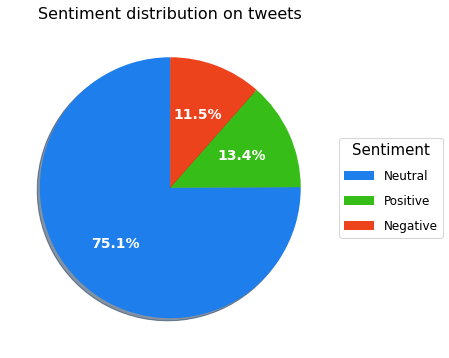

In [9]:
neu, pos, neg = dataset.sentiment.value_counts()

fig, ax = plt.subplots(figsize=(6,6))
colors = ['#1D7EEC','#36BD17','#EC431D']

wedges, texts, autotexts = ax.pie([neu,pos,neg], autopct='%1.1f%%', shadow=True,colors=colors, startangle=90, textprops=dict(color="w"))
ax.legend([neu,pos,neg], labels = ["Neutral", "Positive", "Negative"], title = "Sentiment", 
               loc = "center left", bbox_to_anchor=(1, 0, 0.5, 1), handlelength=2.5, labelspacing=1, fontsize='large', title_fontsize=15)
plt.setp(autotexts, size=14, weight="bold")
ax.set_title("Sentiment distribution on tweets", size=16)


#### **Q. 𝐈𝐈 -- Most Frequent Words**

Most frequent words in the dataset.



In [10]:
from collections import Counter

most_common_words = Counter(" ".join(dataset["text"]).split()).most_common(1000)

most_common_df = pd.DataFrame(most_common_words[:10])
most_common_df = most_common_df.iloc[1:,:]

most_common_df.columns = ['Common_Word','Frequency']
most_common_df.style.background_gradient(cmap='Blues')

,Common_Word,Frequency
1,vaccine,26129
2,moderna,22818
3,dose,22646
4,covid,21524
5,slots,15564
6,age,11209
7,pfizer,7359
8,vaccines,6587
9,sputnikv,6361


**Word Cloud with most frequent words**

In order to run the Word Cloud you have to add to your Google Drive the following files:

* [Word Cloud Mask](https://drive.google.com/file/d/1K3A5Ff0p42rNidxEXYtlPPmTnfCUXF8b/view?usp=sharing)
* [Word Cloud Font](https://drive.google.com/file/d/1G0dtsWIbjxy6Op4oWwsw3Plhs6HBy7Lu/view?usp=sharing)

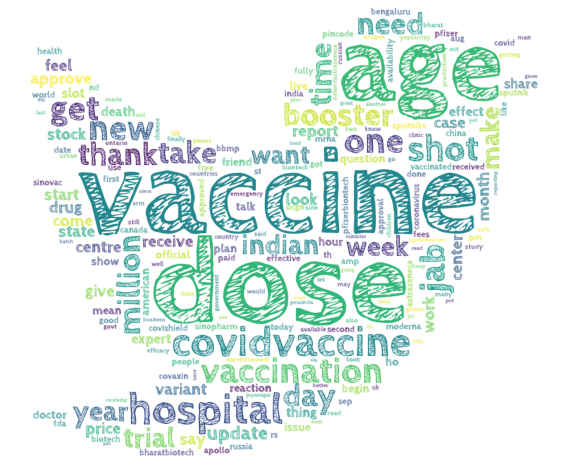

In [11]:
import wordcloud as wc
import imageio

text = " ".join(word[0] for word in most_common_words)

plt.figure(figsize=(10,10))

twitter_mask = imageio.imread('/content/drive/MyDrive/twitter_mask.png')

stop_words = nltk.corpus.stopwords.words('english')

tweet_wordcloud = wc.WordCloud(mask = twitter_mask, 
                                background_color = "white", 
                                stopwords = stop_words,
                                font_path = '/content/drive/MyDrive/CabinSketch-Bold.ttf',
                                width = 1800,
                                height = 1400,
                                ).generate(text)

plt.imshow(tweet_wordcloud)
plt.axis('off')
plt.show()

#### **Q. 𝐈𝐈𝐈 -- Most Frequent Words by Sentiment**

**Most frequent words on `neutral` tweets**

In [12]:
neutral_dataset = dataset[dataset.sentiment == 2]
neutral_most_common = Counter(' '.join(neutral_dataset['text']).split()).most_common(11)

neu_most_common_df = pd.DataFrame(neutral_most_common)
neu_most_common_df = neu_most_common_df.iloc[1:,:]

neu_most_common_df.columns = ['Neu_Common_Word','Frequency']
neu_most_common_df.style.background_gradient(cmap='Blues')

,Neu_Common_Word,Frequency
1,dose,20548
2,vaccine,18983
3,covid,15883
4,slots,15548
5,moderna,15228
6,age,11089
7,bbmp,6277
8,pincode,5419
9,date,5299
10,fees,5044


**Most frequent words on `positive` tweets**

In [13]:
positive_dataset = dataset[dataset.sentiment == 0]
positive_most_common = Counter(' '.join(positive_dataset['text']).split()).most_common(11)

pos_most_common_df = pd.DataFrame(positive_most_common)
pos_most_common_df = pos_most_common_df.iloc[1:,:]

pos_most_common_df.columns = ['Pos_Common_Word','Frequency']
pos_most_common_df.style.background_gradient(cmap='Greens')

,Pos_Common_Word,Frequency
1,moderna,3268
2,covaxin,3198
3,covid,2868
4,vaccinated,1347
5,dose,1280
6,got,1231
7,today,1082
8,first,1039
9,good,962
10,pfizer,958


**Most frequent words on `negative` tweets**

In [14]:
negative_dataset = dataset[dataset.sentiment == 1]
negative_most_common = Counter(' '.join(negative_dataset['text']).split()).most_common(11)

neg_most_common_df = pd.DataFrame(negative_most_common)
neg_most_common_df = neg_most_common_df.iloc[1:,:]
neg_most_common_df.columns = ['Neg_Common_Word','Frequency']
neg_most_common_df.style.background_gradient(cmap='Reds')

,Neg_Common_Word,Frequency
1,vaccine,3550
2,covid,2773
3,covaxin,1771
4,pfizer,1388
5,vaccines,1059
6,people,1048
7,shot,1010
8,got,1001
9,amp,836
10,dose,818


**Frequency of words per sentiment**

In [15]:
neu_most_common_df.rename(columns = {'Neu_Common_Word':'Common_Word'}, inplace = True)
neu_most_common_df['Sentiment'] = 'Neutral'

pos_most_common_df.rename(columns = {'Pos_Common_Word':'Common_Word'}, inplace = True)
pos_most_common_df['Sentiment'] = 'Positive'

neg_most_common_df.rename(columns = {'Neg_Common_Word':'Common_Word'}, inplace = True)
neg_most_common_df['Sentiment'] = 'Negative'

frames = [neu_most_common_df, pos_most_common_df, neg_most_common_df]
  
result = pd.concat(frames) 
# display(result)

Text(0.5, 1.0, 'Frequency of words per sentiment')

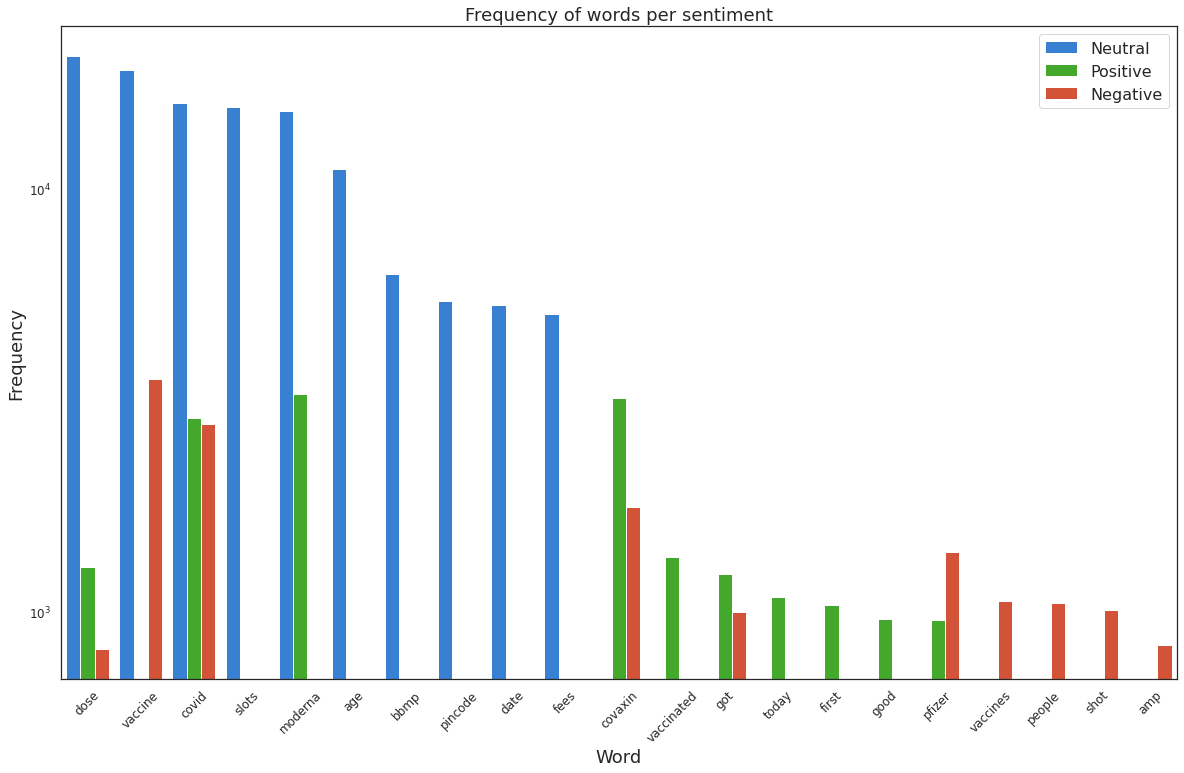

In [16]:
sns.set(rc={'figure.figsize':(20,12)})

sns.set_style('white')

ax = sns.barplot(x='Common_Word', y='Frequency', hue='Sentiment', data=result, palette=['#1D7EEC','#36BD17','#EC431D']) 
ax.set_yscale('log')

plt.legend(loc='upper right', fontsize=16)
plt.xlabel('Word', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=12)
plt.xticks(rotation = 45)
plt.tick_params(axis='y', labelsize=12)
plt.title('Frequency of words per sentiment', 
              fontdict={'fontsize': 18, 'fontweight': 'medium'})


#### **Q. 𝐈𝐕 -- Sentiment Distribution by Vaccine Manufacturer**

Sentiment distribution on tweets that talk about vaccines of AstraZeneca Vs Pfizer/BionTech.


In [17]:
## Get tweets about astrazeneca  ##
subset1 = dataset[dataset['text'].str.contains('astrazeneca')]

In [18]:
# Number of neutral/positive/negative tweets that refer to astrazeneca
s1_neu, s1_pos, s1_neg = subset1.sentiment.value_counts()

In [19]:
## Get tweets about moderna and (pfizer or biontech)  ##
subset2 = dataset[(dataset['text'].str.contains('pfizer') | dataset['text'].str.contains('biontech')) & 
                        dataset['text'].str.contains('moderna')]

In [20]:
s2_neu, s2_pos, s2_neg = subset2.sentiment.value_counts()

Text(0.5, 1.0, 'Number of tweets per sentiment on manufacturers')

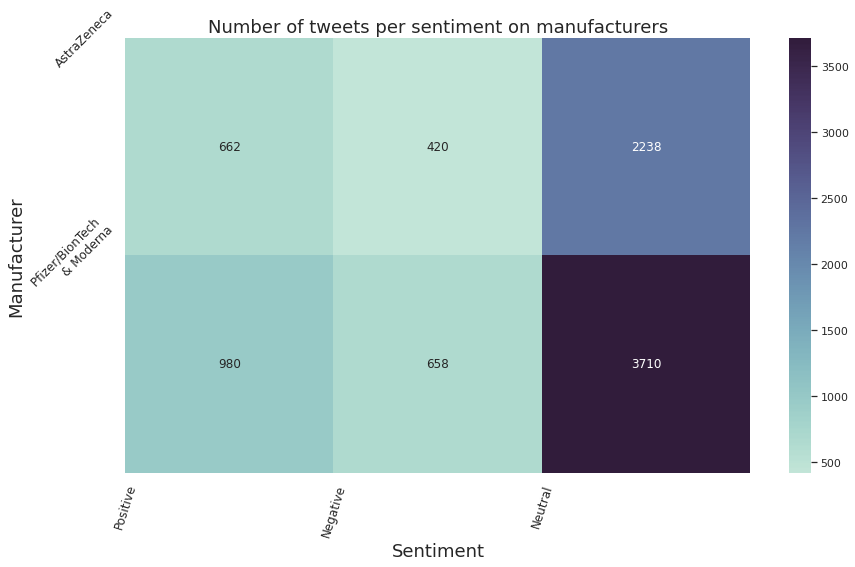

In [21]:
### CREATE HEATMAP ###
AstraZeneca = [s1_pos, s1_neg, s1_neu]
PfizerModerna = [s2_pos, s2_neg, s2_neu]

plt.subplots(figsize=(14,8))  

palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sns.heatmap([AstraZeneca,PfizerModerna], fmt="d", annot=True, cmap=palette)
plt.xticks(ticks= [0,1,2], labels = ["Positive", "Negative", "Neutral"], rotation=72.5)
plt.yticks(ticks = [0,1], labels = ["AstraZeneca", "Pfizer/BionTech \n& Moderna"], rotation=45)
plt.xlabel('Sentiment', fontsize=18)
plt.ylabel('Manufacturer', fontsize=18)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.title('Number of tweets per sentiment on manufacturers', 
              fontdict={'fontsize': 18, 'fontweight': 'medium'})

#### **Q. 𝐕 -- Tweets by Month**

In [22]:
# convert "date" column to datetime format
dataset["date"] = pd.to_datetime(dataset["date"])

In [23]:
# let's see what month the first 5 tweets were posted
dataset["date"].dt.month.head()

64813    4
35009    3
31335    3
22693    3
41242    3
Name: date, dtype: int64

In [24]:
# let's also group tweets by their month and see how many tweets belong to each month
from pandas import Grouper, to_datetime
dataset.groupby([dataset['date'].dt.year, dataset['date'].dt.month])['date'].count()

date  date
2020  12        857
2021  1        1321
      2        4660
      3       12128
      4       11610
      5        8302
      6       15516
      7       12279
      8       12356
      9        7447
      10       7117
      11       6407
Name: date, dtype: int64

In [25]:
grouped = dataset.groupby([ dataset['date'].dt.date])['date']
listDates = []
for key, _ in grouped:
  listDates.append(str(key))

listCount=[]
for count in grouped.count():
  listCount.append(count)

list = []
for i in range(0,len(listCount)):
  date = listDates[i]
  count = listCount[i]
  list.append((date,count))

list2 = []
for member in list:
  date, _ = member
  if date[5:7] == "06":
    list2.append(member)

list2.sort(key=lambda y: y[1], reverse = True)
# print(list2)

In [26]:
grouped = dataset.groupby([dataset['date'].dt.year, dataset['date'].dt.month])['date']

listDates = []
for key, _ in grouped:
  year, date = key
  str_year = str(year)
  str_date = str(date)
  str_date_year = str_date + "/" + str_year
  listDates.append(str_date_year)

# print(listDates)

listCount=[]
for count in grouped.count():
  listCount.append(count)

#print(listCount)

Text(0.5, 1.0, 'Number of Tweets Per Month')

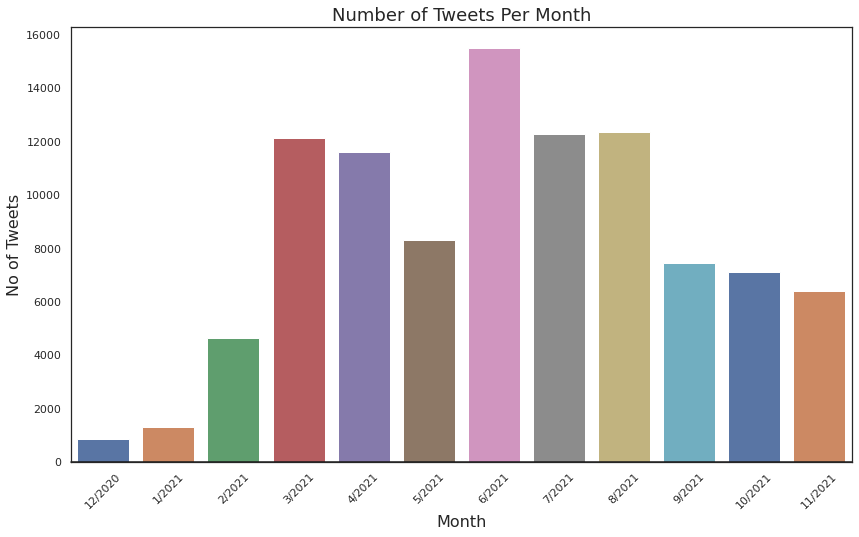

In [27]:
fig, ax = plt.subplots(figsize =(14, 8))

sns.set_theme(style="whitegrid")
br1 = np.arange(len(listCount))
sns.barplot(x=br1, y=listCount, palette="deep")

ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("No of Tweets", fontsize=16)
ax.set_xlabel("Month", fontsize=16)
ax.set_xticks([i for i in range(len(listCount))])
ax.set_xticklabels(labels=listDates)
ax.tick_params(axis='x', labelrotation=45)

ax.set_title("Number of Tweets Per Month", fontsize=18)

**News on the data above** 📰

Observing the results of the above graphic, we draw conclusions that the months with the biggest frequency of tweets are **March, April, June, July and August**. Some of the most important events that happened in those months are the following:

* In **March:**
  * **WHO listed Johnson & Johnson’s COVID-19 vaccine for emergency use** 
  * **Tanzanian President John Magufuli died due to COVID-19** 
  * At the end of March, **WHO releases a report about the origin of the virus**
  
* In **April:**
  * the European Medicines Agency has concluded that **cases of unusual blood clots may be "very rare side effects" of the vaccine** developed by **AstraZeneca**. 
  * U.S. Food and Drug Administration recommends **a pause to the use of the Johnson & Johnson vaccine**. 
  
* In **June:** 
  * **Mauritius approves use of Sputnik Light COVID-19 vaccine** and Cuba releases efficacy results for another vaccine candidate, Abdala.

* In **July:** 
  * European Union officially launches its **digital COVID-19 certificate** 
  * **Pfizer says a third dose of its vaccine could improve immunity**. 

* In **August:**
  * **U.S. regulators approve a booster dose of COVID-19 vaccines for people with compromised immune systems** 
  * U.S. administration announces it will begin offering **booster shots of the Pfizer and Moderna vaccines** to members of the American public *eight months after a second dose*. 
  * U.S. Food and Drug Administration approves the first **COVID-19 vaccine for use by people 16 years old and older** 
  * WHO says it's monitoring **a new variant of COVID-19 known as "mu."**.


So, from the aforementioned events it seems logical to see an increase in the frequency of tweets discussing COVID-19 and vaccines, as some important news has emerged in these months.

#### **Q. 𝐕𝐈 -- Mining Info from Data**

Let's try to draw some extra conclusions on data by answering the following questions.

We are going to study the sentiment distribution on tweets from:

1. **Experts** (including Doctors, Professors, Scientists, etc)
2. **Influencers** (first 100 twitter users according to their followers)
3. **Verified twitter users**

In [28]:
### Sentiment Distribution on verified users tweets ###
dt = dataset2[dataset2.user_verified==True]
neu_user_v, pos_user_v, neg_user_v = dt.sentiment.value_counts()

In [29]:
### Sentiment Distribution on tweets from influencers ###
influencer_dt = dataset2.nlargest(100, 'user_followers')
neu_infl, pos_infl, neg_infl = influencer_dt.sentiment.value_counts()

In [30]:
### Sentiment Distribution on tweets from experts ###
dataset2 = dataset2.dropna()
dataset2['user_description'] = dataset2['user_description'].str.lower()
expert_dt = dataset2[dataset2['user_description'].str.contains('dr|doc|prof|uni|med')]
neu_exp, pos_exp, neg_exp = expert_dt.sentiment.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


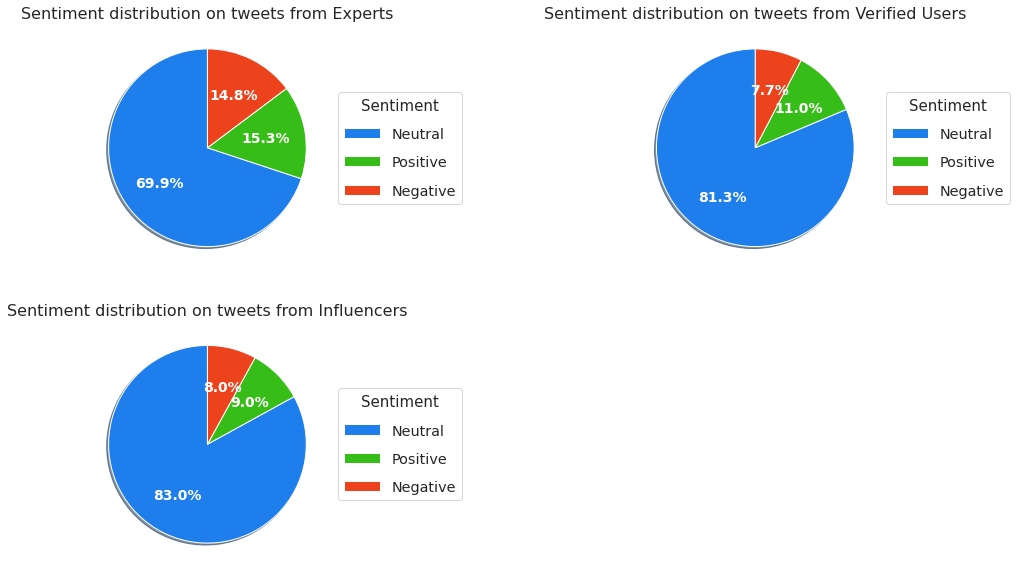

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(18,10), subplot_kw=dict(aspect="equal"))
colors = ['#1D7EEC','#36BD17','#EC431D']

wedges, texts, autotexts = ax[0,0].pie([neu_exp,pos_exp,neg_exp], autopct='%1.1f%%', shadow=True,colors=colors, startangle=90, textprops=dict(color="w"))
ax[0,0].legend([neu_exp,pos_exp,neg_exp], labels = ["Neutral", "Positive", "Negative"], title = "Sentiment", 
               loc = "center left", bbox_to_anchor=(1, 0, 0.5, 1), handlelength=2.5, labelspacing=1, fontsize='large', title_fontsize=15)
plt.setp(autotexts, size=14, weight="bold")
ax[0,0].set_title("Sentiment distribution on tweets from Experts", size=16)

wedges, texts, autotexts = ax[0,1].pie([neu_user_v,pos_user_v,neg_user_v], autopct='%1.1f%%', shadow=True, colors=colors, startangle=90, textprops=dict(color="w"))
ax[0,1].legend([neu_user_v,pos_user_v,neg_user_v], labels = ["Neutral", "Positive", "Negative"], title = "Sentiment", 
               loc = "center left", bbox_to_anchor=(1, 0, 0.5, 1), handlelength=2.5, labelspacing=1, fontsize='large', title_fontsize=15)
plt.setp(autotexts, size=14, weight="bold")
ax[0,1].set_title("Sentiment distribution on tweets from Verified Users", size=16)

wedges, texts, autotexts = ax[1,0].pie([neu_infl,pos_infl,neg_infl], autopct='%1.1f%%', shadow=True, colors=colors, startangle=90, textprops=dict(color="w"))
ax[1,0].legend([neu_infl,pos_infl,neg_infl], labels = ["Neutral", "Positive", "Negative"], title = "Sentiment",
               loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), handlelength=2.5, labelspacing=1, fontsize='large', title_fontsize=15)
plt.setp(autotexts, size=14, weight="bold")
ax[1,0].set_title("Sentiment distribution on tweets from Influencers",size=16)

ax[1,1].remove()

plt.show()

**What can we extract from the above charts?**

* In general, we observe that **most of the tweets are neutral about the COVID-19 vaccines**
* In the tweets that are not neutral, **we see a slight pro-vaccine trend**.
* Tweets posted from experts such as doctors, or professors tend **not to be so neutral** (just ~70%) but to take side (Positive or Negative) on the matter. 

**Commenting the above:** This all makes a lot of sense, as these tweets were posted at the beginning of the pandemic, where there was not as much data and very little research had been done on the subject, so it makes sense that people would be neutral but have a slight leaning towards vaccines that have been proven over the years to be effective against various diseases.


### **Bag of Words 👜**

Data vectorization using the **Bag of Words (BoW)** method.  

Some worth-noting parameters we use are the following:  
* `max_features = 25`
* `min_df = 1` 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(min_df=1, max_features=25, stop_words='english')
bow_vectors = bow_vectorizer.fit_transform(dataset['text'])
bow_vectors = bow_vectors.toarray()

In [10]:
print(bow_vectors.shape)
print(bow_vectors)

(100000, 25)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]]


### **TF-IDF** 🔢

Data vectorization using the **Term Frequency - Inverse Document Frequency** **(TF-IDF)** method.  

Some worth-noting parameters we use are the following:  
* `max_features = 25`
* `min_df = 1` 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=1, max_features=25, stop_words='english')
tfidf_vectors = tfidf_vectorizer.fit_transform(dataset['text'])
tfidf_vectors = tfidf_vectors.toarray()

In [12]:
print(tfidf_vectors.shape) # the output is a numpy array of features
print(tfidf_vectors[0])

(100000, 25)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


### **GloVe** 🧤

Data vectorization using the GloVe *word embeddings*.

We will use the pre-trained `glove.twitter.27B.25d.txt` file which provides 27 billion tokens extracted from tweets and vectorized using the GloVe model in *25* dimensions. The .zip file from GloVe contains encodings in 25, 50, 100 and 200 dimensions. We chose the 25 dimensions for the sake of speed.

First of all we download the `glove.twitter.27B.zip` archive which contains the GloVe word embeddings.

In [13]:
!wget -nc https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip -n -q glove.twitter.27B.zip

File ‘glove.twitter.27B.zip’ already there; not retrieving.



The `glove.twitter.27B.25d.txt` file has the following format:  
Each word is followed by 25 coefficients that define that specific word. We want to build a vocabulary of these words that map each one of them to their corresponding 25-dimensional vector that defines them. So, we go through the file and split each line to get the word and the 25 coefficients that are associated with it. The following code does that.

In [14]:
dimensions = 25
GloVe_path = f'/content/glove.twitter.27B.{dimensions}d.txt'
GloVe_vocab = {}

with open(GloVe_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        GloVe_vocab[word] = coefs

print("Found %s word vectors on the GloVe file." % len(GloVe_vocab))

Found 1193514 word vectors on the GloVe file.


Now that we have the vocabulary with all the words from the GloVe model, we have to build a `word_coeffs` matrix in order to know for each word in the dataset how to represent it with numbers.
Hence, the word coefficients matrix will have dimensions of `[Vocabulary Size] x [Word Vectors Dimension]`.  
But how can we handle the words that are not encoded by the GloVe model?  
⇒ We just fill their word vector with zeros (we kinda ignore them 😁)

So, the idea is the following:
```
If a word from the dataset is also present in the GloVe vocabulary then 
  this word is represented by the 25-dimensional GloVe vector containing the 25 coefficients that represent this word
else (this word is not present in the GloVe vocabulary)
  this word is represented by a 25-diemensional vector filled with zeros
```

The following function, given a dataset returns the NumPy tweet vector with the associated numbers for each tweet, and, how many `words_found`in the dataset.

In [15]:
def GloVe_TweetVectors(dataset):
  words_found = 0
  mean_tweets = []
  all_words = dataset['text'].str.split().str.len().sum()

  for i, row in enumerate(dataset['text']):
    splitted_words = str(row).split(' ')
    word_coeffs = np.zeros((len(splitted_words), dimensions))
    for j, word in enumerate(splitted_words):
      if word in GloVe_vocab:
        word_coeffs[j] = GloVe_vocab[word]
        words_found += 1
    mean_tweets.append(np.mean(word_coeffs, axis=0))
  return np.array(mean_tweets), words_found, all_words

In [16]:
glove_vectors, words_found, all_words = GloVe_TweetVectors(dataset)

In [17]:
print('Match with GloVe embeddings (ratio): ', round(words_found/all_words*100, 2))

Match with GloVe embeddings (ratio):  82.0


So, ~82% of the words present in our dataset are encoded with the GloVe embeddings.

In [18]:
print(glove_vectors.shape)

(100000, 25)


### **Word2Vec** 🔣

Data vectorization using the Word2Vec *word embeddings*.

Some worth-noting parameters we use are the following:  
* `size = 25` (Number of features for each word)
* `window = 5` (Context window size)
* `min_count = 5` (Don't keep the words that appear less than 5 times in the dataset)
* We use the Skip-gram method (an unsupervised learning technique used to find the most related words for a given word)
* We use Negative Sampling (which aims at maximizing the similarity of the words in the same context and minimizing it when they occur in different contexts)
* `epochs = 20` (Train the model for 20 epochs)

In [20]:
import gensim.models

tokenized_tweets = dataset['text'].apply(lambda x: x.split()) # tokenizing

features = 25

word2vec_model = gensim.models.Word2Vec(
                 tokenized_tweets,
                 size = features, # no. of features
                 window = 5, # context window size
                 min_count = 5,
                 sg = 1, # 1 for skip-gram model
                 hs = 0,
                 negative = 10, # for negative sampling
                 workers= 2, # no. of cores
                 seed = 34)

word2vec_model.train(tokenized_tweets, total_examples=len(dataset['text']), epochs=20)

(15303467, 20083240)

In [21]:
word2vec_model.wv.most_similar(positive="trump")

[('trumpwarroom', 0.8606715798377991),
 ('repmtg', 0.8349131941795349),
 ('donaldjtrumpjr', 0.8326797485351562),
 ('catalinalauf', 0.8300095200538635),
 ('biden', 0.8284226655960083),
 ('dictator', 0.8190227150917053),
 ('aoc', 0.8167435526847839),
 ('pandemicresponse', 0.8141705393791199),
 ('kimkbaltimore', 0.8097149133682251),
 ('seanhannity', 0.8068329691886902)]

In [22]:
## Is "biden" present in our word2vec encoded words?
"biden" in word2vec_model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  


True

In [23]:
## What is the w2v vectors shape?
word2vec_model.wv.vectors.shape

(11310, 25)

In [24]:
def W2V_TweetVectors(dataset):
   words_found = 0
   tweet_vectors = []
   all_words = dataset['text'].str.split().str.len().sum()

   for i, row in enumerate(dataset['text']):
     splitted_words = str(row).split(' ')
     word_coeffs = np.zeros((len(splitted_words), features))
     for j, word in enumerate(splitted_words):
       if word in word2vec_model.wv.vocab:
         word_coeffs[j] = word2vec_model[word]
         words_found += 1
     # get the mean of all the words in each tweet 
     tweet_vector = np.mean(word_coeffs, axis=0)
     tweet_vectors.append(tweet_vector)
   return np.array(tweet_vectors), words_found, all_words

In [25]:
w2v_vectors, words_found, all_words = W2V_TweetVectors(dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [26]:
w2v_vectors.shape

(100000, 25)

### **Dataset split** 🖇

In [27]:
from sklearn.model_selection import train_test_split

# BoW data
X_train_bow, X_test_bow, Y_train_bow, Y_test_bow = train_test_split(bow_vectors, dataset['sentiment'], test_size=0.2, random_state=42)

In [28]:
# TF-IDF data
X_train_tfidf, X_test_tfidf, Y_train_tfidf, Y_test_tfidf = train_test_split(tfidf_vectors, dataset['sentiment'], test_size=0.2, random_state=42)

In [29]:
# GloVe
X_train_glove, X_test_glove, Y_train_glove, Y_test_glove = train_test_split(glove_vectors, dataset['sentiment'], test_size=0.2, random_state=42)

In [30]:
# Word2Vec
X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v = train_test_split(w2v_vectors, dataset['sentiment'], test_size=0.2, random_state=42)

In [31]:
print(f"X train BoW shape: {X_train_bow.shape}")
print(f"X train GloVe shape: {X_train_glove.shape}")
print(f"X train TF-IDF shape: {X_train_tfidf.shape}")
print(f"X train W2V shape: {X_train_w2v.shape}")

X train BoW shape: (80000, 25)
X train GloVe shape: (80000, 25)
X train TF-IDF shape: (80000, 25)
X train W2V shape: (80000, 25)


## **Classification** 🏷️

In [32]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

## Define the K-Fold Cross-Validation Metric ##

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro' : 'f1_macro'}

# prepare the cross-validation procedure #
cv = KFold(n_splits=10, random_state=1, shuffle=True)

### **Support Vector Machines** ↔️

#### **SVM with BoW**


In [68]:
from sklearn import svm

SVM = svm.SVC(decision_function_shape='ovo')

start_time = time.time()

SVM.fit(X_train_bow, Y_train_bow)

svm_bow_time = (time.time() - start_time)
print("Training time: %s sec." % svm_bow_time)

Training time: 818.757444858551 sec.


In [69]:
# evaluate model
SVM_scores_bow = cross_validate(SVM, X_test_bow, Y_test_bow, scoring=scoring, cv=cv, n_jobs=-1)

In [70]:
# report performance
print(f"Accuracy: {mean(SVM_scores_bow['test_acc'])*100:.2f}")
print(f"Precision: {mean(SVM_scores_bow['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(SVM_scores_bow['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(SVM_scores_bow['test_f1_macro'])*100:.2f}")

Accuracy: 74.73
Precision: 24.91
Recall: 33.33
F1 Score: 28.51


#### **SVM with TF-IDF**

In [71]:
start_time = time.time()

SVM.fit(X_train_tfidf, Y_train_tfidf)

svm_tfidf_time = (time.time() - start_time)

print("Training time: %s sec." % svm_tfidf_time)

Training time: 659.2288393974304 sec.


In [72]:
SVM_scores_tfidf = cross_validate(SVM, X_test_tfidf, Y_test_tfidf, scoring=scoring, cv=cv, n_jobs=-1)

In [73]:
# report performance
print(f"Accuracy: {mean(SVM_scores_tfidf['test_acc'])*100:.2f}")
print(f"Precision: {mean(SVM_scores_tfidf['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(SVM_scores_tfidf['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(SVM_scores_tfidf['test_f1_macro'])*100:.2f}")

Accuracy: 74.73
Precision: 24.91
Recall: 33.33
F1 Score: 28.51


#### **SVM with Word2Vec** 

In [74]:
start_time = time.time()

SVM.fit(X_train_w2v, Y_train_w2v)

svm_w2v_time = (time.time() - start_time)
print("Training time: %s sec." % svm_w2v_time)

Training time: 413.22755217552185 sec.


In [75]:
SVM_scores_w2v = cross_validate(SVM, X_test_w2v, Y_test_w2v, scoring=scoring, cv=cv, n_jobs=-1)

In [76]:
# report performance
print(f"Accuracy: {mean(SVM_scores_w2v['test_acc'])*100:.2f}")
print(f"Precision: {mean(SVM_scores_w2v['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(SVM_scores_w2v['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(SVM_scores_w2v['test_f1_macro'])*100:.2f}")

Accuracy: 77.55
Precision: 76.97
Recall: 43.23
F1 Score: 46.14


#### **SVM with GloVe**

In [77]:
start_time = time.time()

SVM.fit(X_train_glove, Y_train_glove)

svm_glove_time = (time.time() - start_time)
print("Training time: %s sec." % svm_glove_time)

Training time: 441.9924578666687 sec.


In [78]:
SVM_scores_glove = cross_validate(SVM, X_test_glove, Y_test_glove, scoring=scoring, cv=cv, n_jobs=-1)

In [79]:
# report performance
print(f"Accuracy: {mean(SVM_scores_glove['test_acc'])*100:.2f}")
print(f"Precision: {mean(SVM_scores_glove['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(SVM_scores_glove['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(SVM_scores_glove['test_f1_macro'])*100:.2f}")

Accuracy: 78.29
Precision: 77.89
Recall: 45.34
F1 Score: 49.17


#### **SVM Metrics Table**

In [80]:
svm_bow = [svm_bow_time, mean(SVM_scores_bow['test_acc'])*100, 
                    mean(SVM_scores_bow['test_prec_macro'])*100, 
                    mean(SVM_scores_bow['test_rec_macro'])*100, 
                    mean(SVM_scores_bow['test_f1_macro'])*100]
                    
svm_tfidf = [svm_tfidf_time, mean(SVM_scores_tfidf['test_acc'])*100, 
                    mean(SVM_scores_tfidf['test_prec_macro'])*100, 
                    mean(SVM_scores_tfidf['test_rec_macro'])*100, 
                    mean(SVM_scores_tfidf['test_f1_macro'])*100]

svm_w2v = [svm_w2v_time, mean(SVM_scores_w2v['test_acc'])*100, 
                    mean(SVM_scores_w2v['test_prec_macro'])*100, 
                    mean(SVM_scores_w2v['test_rec_macro'])*100, 
                    mean(SVM_scores_w2v['test_f1_macro'])*100]

svm_glove = [svm_glove_time, mean(SVM_scores_glove['test_acc'])*100, 
                    mean(SVM_scores_glove['test_prec_macro'])*100, 
                    mean(SVM_scores_glove['test_rec_macro'])*100, 
                    mean(SVM_scores_glove['test_f1_macro'])*100]

svm_results = [svm_bow, svm_tfidf, svm_glove, svm_w2v]

svm_df = pd.DataFrame(svm_results,
                      index = ['BoW', 'TF-IDF', 'GloVe', 'Word2Vec'],
                      columns = ['Fit Time (Secs)', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

svm_df.style.set_caption("Support Vector Machines Experiments")

svm_df.style

,Fit Time (Secs),Accuracy,Precision,Recall,F1-Score
BoW,818.757445,74.730000,24.910000,33.333333,28.511234
TF-IDF,659.228839,74.730000,24.911224,33.333333,28.512048
GloVe,441.992458,78.290000,77.889983,45.336610,49.165630
Word2Vec,413.227552,77.550000,76.967355,43.228976,46.139622


### **Random Forests** 🌳 

#### **Random Forests with BoW**

In [33]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_jobs=-1, random_state=43)

start_time = time.time()

RF.fit(X_train_bow, Y_train_bow)

rf_bow_time = (time.time() - start_time)
print("Training time: %s sec." % rf_bow_time)

Training time: 5.568333148956299 sec.


In [34]:
# evaluate model

RF_scores_bow = cross_validate(RF, X_test_bow, Y_test_bow, scoring=scoring, cv=cv, n_jobs=-1, error_score="raise")

In [35]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(RF_scores_bow['test_acc'])*100:.2f}")
print(f"Precision: {mean(RF_scores_bow['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(RF_scores_bow['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(RF_scores_bow['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 73.69
Precision: 37.11
Recall: 33.67
F1 Score: 0.30


#### **Random Forests with TF-IDF**

In [36]:
start_time = time.time()

RF.fit(X_train_tfidf, Y_train_tfidf)

rf_tfidf_time = (time.time() - start_time)
print("Training time: %s sec." % rf_tfidf_time)

Training time: 8.086101055145264 sec.


In [37]:
RF_scores_tfidf = cross_validate(RF, X_test_tfidf, Y_test_tfidf, scoring=scoring, cv=cv, n_jobs=-1)

In [38]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(RF_scores_tfidf['test_acc'])*100:.2f}")
print(f"Precision: {mean(RF_scores_tfidf['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(RF_scores_tfidf['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(RF_scores_tfidf['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 73.77
Precision: 34.67
Recall: 33.45
F1 Score: 0.30


#### **Random Forests with Word2Vec**

In [39]:
start_time = time.time()

RF.fit(X_train_w2v, Y_train_w2v)

rf_w2v_time = (time.time() - start_time)
print("Training time: %s sec." % rf_w2v_time)

Training time: 40.193620681762695 sec.


In [40]:
RF_scores_w2v = cross_validate(RF, X_test_w2v, Y_test_w2v, scoring=scoring, cv=cv, n_jobs=-1)

In [41]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(RF_scores_w2v['test_acc'])*100:.2f}")
print(f"Precision: {mean(RF_scores_w2v['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(RF_scores_w2v['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(RF_scores_w2v['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 79.11
Precision: 74.91
Recall: 50.15
F1 Score: 0.55


#### **Random Forests with GloVe**

In [42]:
start_time = time.time()

RF.fit(X_train_glove, Y_train_glove)

rf_glove_time = (time.time() - start_time)
print("Training time: %s sec." % rf_glove_time)

Training time: 40.48244619369507 sec.


In [43]:
RF_scores_glove = cross_validate(RF, X_test_glove, Y_test_glove, scoring=scoring, cv=cv, n_jobs=-1)

In [44]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(RF_scores_glove['test_acc'])*100:.2f}")
print(f"Precision: {mean(RF_scores_glove['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(RF_scores_glove['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(RF_scores_glove['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 78.59
Precision: 76.08
Recall: 47.17
F1 Score: 0.52


#### **RF Metrics Table**

In [45]:
rf_bow = [rf_bow_time, mean(RF_scores_bow['test_acc'])*100, 
                    mean(RF_scores_bow['test_prec_macro'])*100, 
                    mean(RF_scores_bow['test_rec_macro'])*100, 
                    mean(RF_scores_bow['test_f1_macro'])*100]
                    
rf_tfidf = [rf_tfidf_time, mean(RF_scores_tfidf['test_acc'])*100, 
                    mean(RF_scores_tfidf['test_prec_macro'])*100, 
                    mean(RF_scores_tfidf['test_rec_macro'])*100, 
                    mean(RF_scores_tfidf['test_f1_macro'])*100]

rf_w2v = [rf_w2v_time, mean(RF_scores_w2v['test_acc'])*100, 
                    mean(RF_scores_w2v['test_prec_macro'])*100, 
                    mean(RF_scores_w2v['test_rec_macro'])*100, 
                    mean(RF_scores_w2v['test_f1_macro'])*100]

rf_glove = [rf_glove_time, mean(RF_scores_glove['test_acc'])*100, 
                    mean(RF_scores_glove['test_prec_macro'])*100, 
                    mean(RF_scores_glove['test_rec_macro'])*100, 
                    mean(RF_scores_glove['test_f1_macro'])*100]

rf_results = [rf_bow, rf_tfidf, rf_glove, rf_w2v]

rf_df = pd.DataFrame(rf_results,
                      index = ['BoW', 'TF-IDF', 'GloVe', 'Word2Vec'],
                      columns = ['Fit Time (Secs)', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

rf_df.style.set_caption("Random Forests Experiments")

rf_df.style

,Fit Time (Secs),Accuracy,Precision,Recall,F1-Score
BoW,5.568333,73.685000,37.112524,33.673223,30.090564
TF-IDF,8.086101,73.775000,34.666315,33.449132,29.543680
GloVe,40.482446,78.595000,76.084912,47.174835,51.543212
Word2Vec,40.193621,79.110000,74.906250,50.150256,55.130090


### **K-Nearest Neighbors** 🏠

#### **KNN with BoW**

In [46]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=50, n_jobs=-1)

start_time = time.time()

KNN.fit(X_train_bow, Y_train_bow)

knn_bow_time = (time.time() - start_time)
print("Training time: %s sec." % knn_bow_time)

Training time: 0.011581659317016602 sec.


In [47]:
KNN_scores_bow = cross_validate(KNN, X_test_bow, Y_test_bow, scoring=scoring, cv=cv, n_jobs=-1)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [48]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(KNN_scores_bow['test_acc'])*100:.2f}")
print(f"Precision: {mean(KNN_scores_bow['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(KNN_scores_bow['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(KNN_scores_bow['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 74.71
Precision: 26.02
Recall: 33.35
F1 Score: 0.29


#### **KNN with TF-IDF**

In [49]:
start_time = time.time()

KNN.fit(X_train_tfidf, Y_train_tfidf)

knn_tfidf_time = (time.time() - start_time)
print("Training time: %s sec." % knn_tfidf_time)

Training time: 0.02162623405456543 sec.


In [50]:
KNN_scores_tfidf = cross_validate(KNN, X_test_tfidf, Y_test_tfidf, scoring=scoring, cv=cv, n_jobs=-1)

In [51]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(KNN_scores_tfidf['test_acc'])*100:.2f}")
print(f"Precision: {mean(KNN_scores_tfidf['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(KNN_scores_tfidf['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(KNN_scores_tfidf['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 74.68
Precision: 25.24
Recall: 33.32
F1 Score: 0.29


#### **KNN with Word2Vec**

In [52]:
start_time = time.time()

KNN.fit(X_train_w2v, Y_train_w2v)

knn_w2v_time = (time.time() - start_time)
print("Training time: %s sec." % knn_w2v_time)

Training time: 0.01808786392211914 sec.


In [53]:
KNN_scores_w2v = cross_validate(KNN, X_test_w2v, Y_test_w2v, scoring=scoring, cv=cv, n_jobs=-1)

In [54]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(KNN_scores_w2v['test_acc'])*100:.2f}")
print(f"Precision: {mean(KNN_scores_w2v['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(KNN_scores_w2v['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(KNN_scores_w2v['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 78.15
Precision: 73.13
Recall: 47.69
F1 Score: 0.52


#### **KNN with GloVe**

In [55]:
start_time = time.time()

KNN.fit(X_train_glove, Y_train_glove)

knn_glove_time = (time.time() - start_time)
print("Training time: %s sec." % knn_glove_time)

Training time: 0.014880895614624023 sec.


In [56]:
KNN_scores_glove = cross_validate(KNN, X_test_glove, Y_test_glove, scoring=scoring, cv=cv, n_jobs=-1)

In [57]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(KNN_scores_glove['test_acc'])*100:.2f}")
print(f"Precision: {mean(KNN_scores_glove['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(KNN_scores_glove['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(KNN_scores_glove['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 77.33
Precision: 76.04
Recall: 42.43
F1 Score: 0.45


#### **KNN Metrics Table**

In [58]:
knn_bow = [knn_bow_time, mean(KNN_scores_bow['test_acc'])*100, 
                    mean(KNN_scores_bow['test_prec_macro'])*100, 
                    mean(KNN_scores_bow['test_rec_macro'])*100, 
                    mean(KNN_scores_bow['test_f1_macro'])*100]
                    
knn_tfidf = [knn_tfidf_time, mean(KNN_scores_tfidf['test_acc'])*100, 
                    mean(KNN_scores_tfidf['test_prec_macro'])*100, 
                    mean(KNN_scores_tfidf['test_rec_macro'])*100, 
                    mean(KNN_scores_tfidf['test_f1_macro'])*100]

knn_w2v = [knn_w2v_time, mean(KNN_scores_w2v['test_acc'])*100, 
                    mean(KNN_scores_w2v['test_prec_macro'])*100, 
                    mean(KNN_scores_w2v['test_rec_macro'])*100, 
                    mean(KNN_scores_w2v['test_f1_macro'])*100]

knn_glove = [knn_glove_time, mean(KNN_scores_glove['test_acc'])*100, 
                    mean(KNN_scores_glove['test_prec_macro'])*100, 
                    mean(KNN_scores_glove['test_rec_macro'])*100, 
                    mean(KNN_scores_glove['test_f1_macro'])*100]

knn_results = [knn_bow, knn_tfidf, knn_glove, knn_w2v]

knn_df = pd.DataFrame(knn_results,
                      index = ['BoW', 'TF-IDF', 'GloVe', 'Word2Vec'],
                      columns = ['Fit Time (Secs)', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

knn_df.style.set_caption("K-Nearest Neighbors Experiments")

knn_df.style

,Fit Time (Secs),Accuracy,Precision,Recall,F1-Score
BoW,0.011582,74.715000,26.022910,33.349021,28.560382
TF-IDF,0.021626,74.680000,25.240122,33.322427,28.525781
GloVe,0.014881,77.325000,76.043731,42.427897,44.892535
Word2Vec,0.018088,78.145000,73.134784,47.685270,52.014665


### **Classifiers comparison and metrics 📊**

We run again *each* classifier for *each* vectorization method and we examine the results through some graphs.

In [102]:
def classification(X_test, Y_test, X_train, Y_train, classifier, cv):
  classifier.fit(X_train, Y_train)
  scores = cross_validate(classifier, X_test, Y_test, scoring=scoring, cv=cv, n_jobs=-1)
  return scores

In [103]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from numpy import mean

SVM = svm.SVC(decision_function_shape='ovo')
RF = RandomForestClassifier()
KNN = KNeighborsClassifier(n_neighbors=50)

Classifiers = [SVM, RF, KNN]

X_tests = [X_test_bow, X_test_tfidf, X_test_w2v, X_test_w2v]
Y_tests = [Y_test_bow, Y_test_tfidf, Y_test_w2v, Y_test_w2v]
X_trains = [X_train_bow, X_train_tfidf, X_train_w2v, X_train_w2v]
Y_trains = [Y_train_bow, Y_train_tfidf, Y_train_w2v, Y_train_w2v]

BOW_scores = []
TF_IDF_scores = []
W2V_scores = []
GloVe_scores = []
BOW_acc=[]
BOW_prec=[]
BOW_rec=[]
BOW_F1=[]
TF_IDF_acc=[]
TF_IDF_prec=[]
TF_IDF_rec=[]
TF_IDF_F1=[]
W2V_acc=[]
W2V_prec=[]
W2V_rec=[]
W2V_F1=[]
GloVe_acc=[]
GloVe_prec=[]
GloVe_rec=[]
GloVe_F1=[]

# 10-Fold Cross Validation #
cv = KFold(n_splits=10, random_state=1, shuffle=True)

for i in range(len(X_tests)):
  X_test = X_tests[i]
  Y_test = Y_tests[i]
  X_train = X_trains[i]
  Y_train = Y_trains[i]
  
  for classifier in Classifiers:
    score = classification(X_test, Y_test, X_train, Y_train, classifier, cv)
    
    scores = {
        "Accuracy" : mean(score['test_acc'])*100,
        "Precision" : mean(score['test_prec_macro'])*100,
        "Recall" : mean(score['test_rec_macro'])*100,
        "F1" : mean(score['test_f1_macro'])*100
    }

    if i == 0:
      BOW_scores.append(scores)
      BOW_acc.append(round(scores['Accuracy'],2))
      BOW_prec.append(round(scores['Precision'],2))
      BOW_rec.append(round(scores['Recall'],2))
      BOW_F1.append(round(scores['F1'],2))
    elif i == 1:
      TF_IDF_scores.append(scores)
      TF_IDF_acc.append(round(scores['Accuracy'],2))
      TF_IDF_prec.append(round(scores['Precision'],2))
      TF_IDF_rec.append(round(scores['Recall'],2))
      TF_IDF_F1.append(round(scores['F1'],2))
    elif i == 2:
      W2V_scores.append(scores)
      W2V_acc.append(round(scores['Accuracy'],2))
      W2V_prec.append(round(scores['Precision'],2))
      W2V_rec.append(round(scores['Recall'],2))
      W2V_F1.append(round(scores['F1'],2))
    else:
      GloVe_scores.append(scores)
      GloVe_acc.append(round(scores['Accuracy'],2))
      GloVe_prec.append(round(scores['Precision'],2))
      GloVe_rec.append(round(scores['Recall'],2))
      GloVe_F1.append(round(scores['F1'],2))

In [104]:
acc_data = [BOW_acc, TF_IDF_acc, W2V_acc, GloVe_acc]
prec_data = [BOW_prec, TF_IDF_prec, W2V_prec, GloVe_prec]
rec_data = [BOW_rec, TF_IDF_rec, W2V_rec, GloVe_rec]
F1_data = [BOW_F1, TF_IDF_F1, W2V_F1, GloVe_F1]

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def classifiers_metric_plot(data, metric, max_range):
  columns = ('SVM', 'Random Forests', 'KNN')
  rows = ('BoW', 'TF-IDF', 'Word2Vec', 'GloVe')

  values = np.arange(0, 4*max_range+10, 50)

  plt.subplots(figsize=(8,6))

  # Get some pastel shades for the colors
  colors = plt.cm.Paired(np.linspace(0, 0.5, len(rows)))

  bar_width = 0.4
  n_rows = len(data)
  index = np.arange(len(columns)) + 0.3

  # Initialize the vertical-offset for the stacked bar chart.
  y_offset = np.zeros(len(columns))

  # Plot bars and create text labels for the table
  for row in range(n_rows):
      p = plt.bar(index, data[row], bar_width, bottom=y_offset, 
                  color=colors[row], data=data[row])
      y_offset = y_offset + data[row]

  # Reverse colors and text labels to display the last value at the top.
  colors = colors[::-1]

  # Add a table at the bottom of the axes
  the_table = plt.table(cellText=data,
                        rowLabels=rows,
                        rowColours=colors,
                        colLabels=columns,
                        loc='bottom')

  the_table.scale(xscale=1.0, yscale=1.4)

  # Adjust layout to make room for the table:
  plt.subplots_adjust(left=0.2, bottom=0.2, hspace=1.0)

  plt.title("Classifiers Performance")
  plt.ylabel(f"{metric} Score", fontdict={"fontsize" : 12})
  plt.yticks(values, ['%d' % val for val in values])
  plt.xticks([])

  plt.show()

#### **Accuracy Comparison**

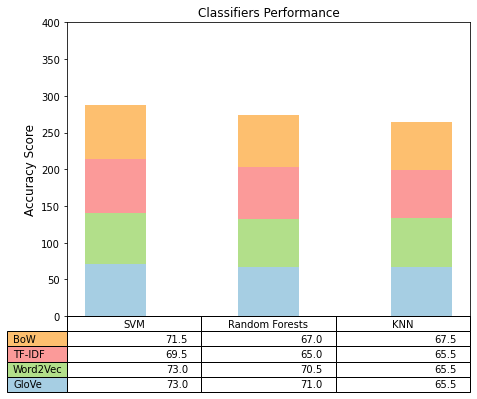

In [184]:
### Accuracy comparison ###
classifiers_metric_plot(acc_data, "Accuracy", 100)

#### **Precision Comparison**

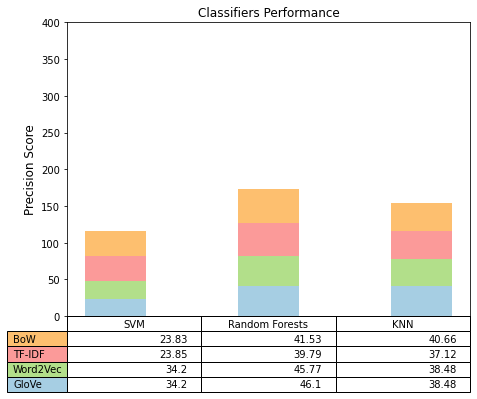

In [185]:
### Precision comparison ###
classifiers_metric_plot(prec_data, "Precision", 100)

#### **Recall Comparison**

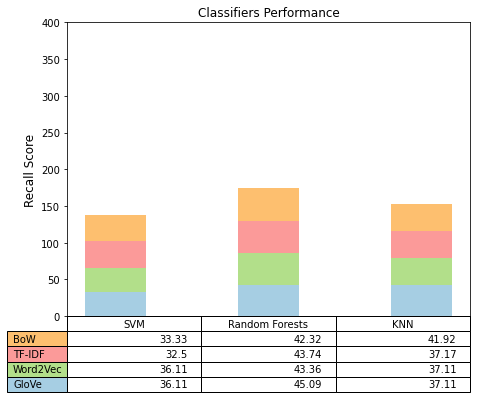

In [186]:
### Recall comparison ###
classifiers_metric_plot(rec_data, "Recall", 100)

#### **F1-Score Comparison**

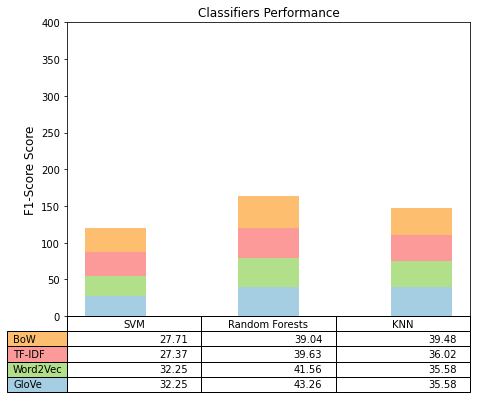

In [187]:
### F1-Score comparison ###
classifiers_metric_plot(F1_data, "F1-Score", 100)

### **Beat the Benchmark 🚀**

In this section, we are going to try to beat our previous best score which was ~78%.  
We are going to do the following:

* Will lemmatize the data
* Use Word2Vec vectorization method
* Use the KNN and RF Classifiers

#### **Clean the data**

In [59]:
!pip install contractions
import contractions

     |████████████████████████████████| 287 kB 7.7 MB/s 
     |████████████████████████████████| 106 kB 56.4 MB/s 


In [60]:
!pip install emoji
import emoji

     |████████████████████████████████| 175 kB 8.6 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=623570f1e6fde86475165099c0f1317254cdafb5f41a3ef3d02fb4a58e2c04b7
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [61]:
def text_cleaning_v2(text):
  # Convert emojis to text
  emoji.demojize(text, delimiters=("", ""))
  text = re.sub('_', " ", text)
  # text = re.sub('face', "", text)
  contractions.fix(text)
  # Lower characters
  text = text.lower()
  # Remove links
  text = re.sub('http://\S+|https://\S+', '', text)
  # Remove non alphanumeric characters
  text = re.sub(r'[^A-Za-z]+', ' ', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  StopWords = stopwords.words("english")
  text = ' '.join([word for word in text.split() if word not in StopWords])
  # Remove words with length < 3
  text = ' '.join([word for word in text.split() if len(word) >= 3])

  return text

In [62]:
dataset4Benchmark['text'] = dataset4Benchmark['text'].apply(text_cleaning_v2)

#### **Lemmatize the data**

In [63]:
nltk.download('wordnet')

w_tokenizer = nltk.TweetTokenizer()
lemmatizer = nltk.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
 
def lemmatization_and_stemming(text):
    return " ".join([lemmatizer.lemmatize(stemmer.stem(w)) for w in w_tokenizer.tokenize(text)])

dataset4Benchmark['text'] = dataset4Benchmark.text.apply(lemmatization_and_stemming).copy()

dataset4Benchmark.head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
64813,1384446688237133825,ExperiencedTraveller,London,"Addicted to all things related to travel - talk, write and tweet about it - my main outlet is https://t.co/7K8nH6rLku",2010-04-21 20:43:27,10309,11230,280,False,2021-04-20 09:59:46,mondayblog coronavirusdiari record week coronaviruspandem sad news princephilip,"['MondayBlogs', 'coronavirusdiary', 'coronaviruspandemic', 'PrincePhilip']",Twitter Web App,0,0,False,NEG
35009,1373922903234912256,Liam Thomas Politics #StayAlertSaveLives,United Kingdom,Tweeting the day’s unfolding political stories and breaking news. Morning and Evening summaries. Mon-Fri 9AM - 7PM. Sat 9AM - 5PM,2017-06-28 16:56:47,32,1324,1262,False,2021-03-22 09:02:01,good morn even summari bori johnson expect speak counterpart week row,NaN,Twitter for iPad,0,0,False,NEU
31335,1372277188335173635,Karen Parrish,"High Point, NC","Wife of Robin, author of books; Mom of Evan and Emma. Lover of cake and fruit.",2008-07-24 19:06:33,41,396,587,False,2021-03-17 20:02:32,got shot well first one least notthrowingawaymyshot moderna,"['notthrowingawaymyshot', 'moderna']",Instagram,0,0,False,NEG
22693,1367836353124167683,ranjan kumar,NaN,NaN,2017-01-13 14:11:12,25,56,49,False,2021-03-05 13:56:14,congress left parti put live common peopl risk polit congress covid,"['Congress', 'COVID19']",Twitter for Android,1,0,False,NEG
41242,1376539297319317507,Workout Solutions,"Toronto, Canada and Worldwide","George Tsanis – Workout Solutions Health and Fitness Consultants since 1996 – One-on-one and online distance coaching – Toronto, Canada, World",2010-09-20 17:01:08,1190,206,1837,False,2021-03-29 14:18:38,celliott moscow russia everyth open busi usual ontario canada report case,NaN,Twitter for iPhone,1,0,False,NEU
211801,1449972460149886977,Kabira,Nidavellir,Way cooler in reality than on Twitter....!!,2012-04-11 09:53:13,3319,1466,60247,False,2021-10-18 05:35:48,sound like posit develop hope vaccin approv oct end covaxin,['Covaxin'],Twitter for iPhone,0,5,False,POS
204940,1447838056879325187,Dr.Sanjiv Pandey डॉ. संजीव पाण्डेय,हिन्दुस्तान,"Proud to be a Doctor, Nationalist, Social Activist.\nRSS-VHP Supporter. #चमचे_सेकुलर_लिबरल_दूर_रहे 🛕🚩जय श्रीराम • हर हर महादेव🚩🕉️ जयतु सनातन धर्मः",2017-11-08 17:53:05,2271,2296,9738,False,2021-10-12 08:14:26,bharat biotech covaxin get emerg use approv child year age covaxin,['Covaxin'],Twitter for Android,0,0,False,NEU
5867,1358764826680565762,"Russian Embassy, UK",London,Embassy of the Russian Federation 🇷🇺in London - official Twitter feed (на русском языке - @RussianEmbassyR),2010-02-16 11:26:37,89271,1653,2613,True,2021-02-08 13:09:13,good news covid nicaragua amp lebanon approv sputnikvaccin emerg use authoris pro,['covid19'],Twitter Web App,25,49,False,POS
82326,1398883179990327296,𝓐𝓶𝓳𝓪𝓭 𝓥𝓮𝓱𝓷𝓲𝔀𝓪𝓵,ملتان / وہاڑی,Husband to @Aqsamjad MPhil by education Cricket fan highly non political and good listener,2012-04-10 08:03:33,425,135,29048,False,2021-05-30 06:05:14,drmuradpti done sir govtofpunjabpk excel arang vaccin sinovac,"['vaccinated', 'Sinovac']",Twitter for Android,0,0,False,POS
106186,1407767965563461633,CowinBangalore,NaN,Follow us to get update as soon as 18 plus vaccine appointments open up in Bangalore & Covaxin for 45+ #TwitterBot\nTelegram: https://t.co/WavSl590z5,2021-05-17 18:56:45,1116,2,57,False,2021-06-23 18:30:12,age slot covaxin halli uphc free bbmp,"['COVAXIN', 'BBMP']",cowin_vaccine_app,0,0,False,NEU


#### **Word2Vec**

In [64]:
tokenized_tweets = dataset4Benchmark['text'].apply(lambda x: x.split()) # tokenizing

features = 25

word2vec_model = gensim.models.Word2Vec(
                 tokenized_tweets,
                 size = features, # no. of features
                 window = 5, # context window size
                 min_count = 5,
                 sg = 1, # 1 for skip-gram model
                 hs = 0,
                 negative = 10, # for negative sampling
                 workers = 2, # no. of cores
                 seed = 34)

word2vec_model.train(tokenized_tweets, total_examples=len(dataset4Benchmark['text']), epochs=20)

(14003702, 19074500)

In [65]:
w2v_vectors_new, words_found, all_words = W2V_TweetVectors(dataset4Benchmark)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [66]:
# Word2Vec
X_train_w2v_new, X_test_w2v_new, Y_train_w2v_new, Y_test_w2v_new = \
  train_test_split(w2v_vectors_new, dataset['sentiment'], test_size=0.2, random_state=42)

#### **KNN on Word2Vec**

In [67]:
start_time = time.time()

KNN.fit(X_train_w2v_new, Y_train_w2v_new)

print("Training time: %s sec." % (time.time() - start_time))

Training time: 0.011732101440429688 sec.


In [68]:
KNN_scores_w2v = cross_validate(KNN, X_test_w2v_new, Y_test_w2v_new, scoring=scoring, cv=cv, n_jobs=-1)

In [69]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(KNN_scores_w2v['test_acc'])*100:.2f}")
print(f"Precision: {mean(KNN_scores_w2v['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(KNN_scores_w2v['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(KNN_scores_w2v['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 78.36
Precision: 73.64
Recall: 48.23
F1 Score: 0.53


#### **RF with Word2Vec**

In [70]:
start_time = time.time()

RF.fit(X_train_w2v_new, Y_train_w2v_new)

print("Training time: %s sec." % (time.time() - start_time))

Training time: 39.554203033447266 sec.


In [71]:
RF_scores_w2v = cross_validate(RF, X_test_w2v_new, Y_test_w2v_new, scoring=scoring, cv=cv, n_jobs=-1)

In [72]:
# report performance
print("PERFORMANCE METRICS\n")
print(f"Accuracy: {mean(RF_scores_w2v['test_acc'])*100:.2f}")
print(f"Precision: {mean(RF_scores_w2v['test_prec_macro'])*100:.2f}")
print(f"Recall: {mean(RF_scores_w2v['test_rec_macro'])*100:.2f}")
print(f"F1 Score: {mean(RF_scores_w2v['test_f1_macro']):.2f}")

PERFORMANCE METRICS

Accuracy: 79.33
Precision: 75.49
Recall: 50.83
F1 Score: 0.56


#### **Did we make it?**

We tried to beat our previous best scores on KNN and Random Forests classifiers both trained on Word2Vec encoded data.  
In addition to the previous data preprocessing we tried the following:

* Remove words with length less than 3 (as these words may be meaningless)
* Lemmatization and Stemming

**Some numbers**  
As the metrics show, we outperformed our previous best performance on both classifiers (KNN & RF). As the following table shows, we have a **~0.4%** increase on accuracy on both classifiers, and so, ***we did beat the benchmark*** 🎉!

Classifier | Previous Best | New Best |
-- | -- | -- |
K-Nearest Neighbor | 78.04% | 78.50%  
Random Forests | 78.90% | 79.27%  

## **Latent Dirichlet Allocation (LDA)** 📍

#### **Tokenization, Lemmatization, and Stemming**


In [73]:
nltk.download('wordnet')

w_tokenizer = nltk.TweetTokenizer()
lemmatizer = nltk.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
 
def lemmatization_and_stemming(text):
    return " ".join([lemmatizer.lemmatize(stemmer.stem(w)) for w in w_tokenizer.tokenize(text)])

dataset['text'] = dataset.text.apply(lemmatization_and_stemming).copy()

dataset.head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,date,text,sentiment
64813,2021-04-20 09:59:46,mondayblog coronavirusdiari record week coronaviruspandem sad news princephilip,1
35009,2021-03-22 09:02:01,good morn even summari pm bori johnson expect speak eu counterpart week row,2
31335,2021-03-17 20:02:32,got shot well first one least notthrowingawaymyshot moderna,1
22693,2021-03-05 13:56:14,congress left parti put live common peopl risk polit congress covid,1
41242,2021-03-29 14:18:38,celliott moscow russia everyth open busi usual ontario canada report case,2
211801,2021-10-18 05:35:48,sound like posit develop hope vaccin approv oct end covaxin,0
204940,2021-10-12 08:14:26,bharat biotech covaxin get emerg use approv child year age covaxin,2
5867,2021-02-08 13:09:13,good news covid nicaragua amp lebanon approv sputnikvaccin emerg use authoris pro,0
82326,2021-05-30 06:05:14,drmuradpti done sir govtofpunjabpk excel arang vaccin sinovac,0
106186,2021-06-23 18:30:12,age slot covaxin p g halli uphc free bbmp,2


The two main inputs to the LDA topic model are the dictionary (`id2word`) and the corpus (`doc_term_matrix`), so let's create them.

In order to create the dictionary (`id2word`) we have to get our data in a form of list of lists, where each document (tweet) is represented by a list of its words and all the lists are contained in a big list (`texts`).

In [74]:
# we need to keep all documents (tweets) as a big list
# where each tweet is a list of its words (tokens)
# let's call this "texts"

texts = [] 

for row in dataset['text']:
  row_list = []
  for word in row.split():
    row_list.append(word)
  texts.append(row_list)

#### **Create the dictionary**

In [76]:
from gensim import corpora

id2word = corpora.Dictionary(texts)

print(id2word)

Dictionary(47728 unique tokens: ['coronavirusdiari', 'coronaviruspandem', 'mondayblog', 'news', 'princephilip']...)


#### **Create the corpus**

Corpus (`doc_term_matrix`) is a mapping of (word-id, word-frequency).

In [77]:
# Converting list of documents (corpus) into Document Term Matrix using the dictionary 

doc_term_matrix = [id2word.doc2bow(text) for text in texts]
doc_term_matrix

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1)],
 [(49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1)],
 [(49, 1),
  (50, 2),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1)],
 [(3, 1),
  (13, 1),
  (30, 1),
  (49, 1),
  (63, 1),
  (65, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1)],
 [(58, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)],
 [(50, 1),
  (59, 1),
  (80, 1),
  (81, 1),
  (82, 1),


#### **LDA Topic Model Definition**

Let's define some hyperparameters of the model:

* `alpha` and `eta` affect the sparsity of the topics
* `chunksize` is the number of documents to be used in each training chunk
* `update_every` determines how often the model parameters should be updated
* `passes` is the total number of training passes

In [78]:
# Creating the object for LDA model using gensim library
import gensim

lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# will get us the keywords for each topic with their associated weightage #
lda_model.print_topics()

[(0,
  '0.121*"covaxin" + 0.059*"dose" + 0.058*"slot" + 0.057*"age" + 0.023*"bbmp" + 0.021*"hospit" + 0.020*"pincod" + 0.019*"date" + 0.019*"r" + 0.018*"covishield"'),
 (1,
  '0.057*"vaccin" + 0.030*"moderna" + 0.029*"covid" + 0.014*"dose" + 0.010*"pfizer" + 0.009*"get" + 0.008*"sputnikv" + 0.008*"first" + 0.008*"approv" + 0.007*"got"')]

#### **Coherence and Perplexity Scores**

In [79]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

# Compute Coherence Score
print('\nCoherence Score: ', coherence_lda)
# Compute Perplexity: a measure of how good the model is. The lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  


Coherence Score:  0.3109009379052983

Perplexity:  -7.313886572870875


#### **Hyperparameters Tuning**

In [83]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    optimal_coherence : Optimal coherence value
    optimal_n_topics : Optimal number of topics
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    optimal_coherence = -1000
    optimal_n_topics = None
    coherence_values = []
    for num_topics in range(start, limit, 6):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=1,
                                           alpha='auto',
                                           per_word_topics=True)

        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        cc = coherencemodel.get_coherence()
        coherence_values.append(cc)
        if cc > optimal_coherence:
          optimal_coherence = cc
          optimal_n_topics = num_topics

    return optimal_coherence, optimal_n_topics, coherence_values

In [84]:
start = 2
limit = 40

optimal_coherence, optimal_topics, coherence_values = \
  compute_coherence_values(id2word, doc_term_matrix, texts, limit, start=2)

In [85]:
print(optimal_coherence)
print(optimal_topics)

0.3787345596987443
38


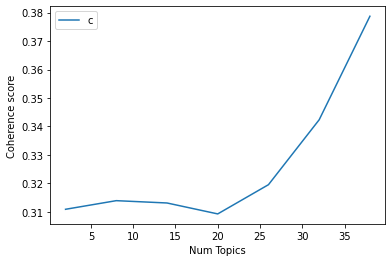

In [86]:
# Show graph
x = range(start, limit, 6)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### **Run the optimal LDA Topic Model**

In [87]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=id2word,
                                           num_topics=optimal_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=1,
                                           alpha='auto',
                                           per_word_topics=True)

#### **Visualize the Topics**

In [88]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models 

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, id2word)
vis

     |████████████████████████████████| 1.7 MB 8.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=5f7f7811b4cca40614d7ac955eb809b937a2727a7e057f91cf6b8c4326da3422
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.133415 -0.327125       1        1  12.460706
28    -0.225250  0.237484       2        1   5.158982
16    -0.228835 -0.203857       3        1   4.227922
35    -0.371456  0.030491       4        1   4.173440
33    -0.328674  0.208577       5        1   3.778632
14     0.040973 -0.010645       6        1   2.991412
24     0.041716  0.002903       7        1   2.897844
11     0.045258  0.002084       8        1   2.817184
10     0.026731 -0.029826       9        1   2.785959
13    -0.109331 -0.133908      10        1   2.652564
31     0.052529  0.009339      11        1   2.467671
22     0.051920  0.007161      12        1   2.464039
30     0.045589 -0.051347      13        1   2.424161
3      0.050786  0.007883      14        1   2.281497
17     0.048408  0.004372      15        1   2.268169
8      0.040741  0.004635      16        1   2.207783
9      0.056141  0.011334      17        1   2.143841
15     0.043545  0.026199      18        1   2.133664
12     0.054695  0.014336      19        1   2.075719
21     0.058363  0.011061      20        1   2.022537
5      0.054805  0.015149      21        1   2.005960
0      0.055238  0.012386      22        1   1.983235
34    -0.179209 -0.078764      23        1   1.978224
37     0.056981  0.014401      24        1   1.970168
27     0.054593  0.006860      25        1   1.965215
6      0.056731  0.009573      26        1   1.962743
29     0.056165  0.009965      27        1   1.942029
2      0.058383  0.014871      28        1   1.932918
23     0.058517  0.020148      29        1   1.924850
25     0.058330  0.017110      30        1   1.891249
26     0.054358  0.016593      31        1   1.888439
1      0.062191  0.019464      32        1   1.885084
4      0.050474  0.001451      33        1   1.814789
19     0.052302  0.013137      34        1   1.802992
32     0.061462  0.014046      35        1   1.783992
36     0.025404  0.062413      36        1   1.711159
20     0.054848  0.022141      37        1   1.576179
7      0.047993 -0.012094      38        1   1.547050, topic_info=             Term          Freq         Total Category  logprob  loglift
58         vaccin  44789.000000  44789.000000  Default  30.0000  30.0000
50        covaxin  31395.000000  31395.000000  Default  29.0000  29.0000
30          covid  22284.000000  22284.000000  Default  28.0000  28.0000
23        moderna  23353.000000  23353.000000  Default  27.0000  27.0000
89           dose  24547.000000  24547.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
2350          ten    129.161544    130.105324  Topic38  -4.7898   4.1615
111           opp    119.588581    120.532360  Topic38  -4.8668   4.1610
4262        spike    117.215433    118.159212  Topic38  -4.8868   4.1608
1276  nihdirector    112.869046    113.812825  Topic38  -4.9246   4.1605
1495          con    110.065771    111.009550  Topic38  -4.9498   4.1603

[1193 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
146       4  0.995663   aarthi
1996     21  0.996925      abl
2648     12  0.993336   abroad
926      14  0.992591  absolut
140      28  0.996017   accept
...     ...       ...      ...
1557     26  0.996301       yo
245       4  0.993939    young
2873     31  0.997018   youtub
1185     37  0.995850       yr
1378     15  0.990953  zimbabw

[1172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 29, 17, 36, 34, 15, 25, 12, 11, 14, 32, 23, 31, 4, 18, 9, 10, 16, 13, 22, 6, 1, 35, 38, 28, 7, 30, 3, 24, 26, 27, 2, 5, 20, 33, 37, 21, 8])

## **Summary 💭**

We experimented with various classification algorithms and various vectorization methods in order to convert our tweets to feature numbers and then classify them as neutral, positive or negative.

Here is what we observed at a glance:

* Our best model got **accuracy of ~79%** and had the following properties:
  * **Classifier:** Random Forests with 50 estimators
  * **Vectorization Method:** Word2Vec with 25 features
  * **Fit time:** ~40 secs.

* Metric used: **10-Fold Cross Validation**

* **We used 100K tweets** out of the ~230K present in the whole dataset. We tried classification using the whole dataset but the *accuracy increased just 1% and it took way longer*.

* We tried to fit the classifiers using 150 & 200 features but not only *they took way longer* they *performed almost the same as with 25 features*! 

* Word embeddings, both Word2Vec and GloVe they **performed better** than BoW or TF-IDF vectorization techniques. This makes sense, as the word embeddings capture more meaningful information about the words in each tweet. In addition, **Word2Vec performed better from GloVe.**

* **SVM takes a lot of time** (~10') to fit the training data while Random Forests need about 30 seconds and KNN instantly.

As a final thing, we can say that our best option for classification is the Random Forests classifier and the K-Nearest Neighbors. Both of them are both fast and accurate. 

**Authors:**

* Angelos Poulis (sdi1900230)
* Dimitrios Kyriakopoulos (sdi1900093)